In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import seaborn as sns
from IPython.display import display, Markdown

import numpy as np
import rasterio
import geopandas as gpd

from gridfinder._util import save_raster, clip_line_poly
from gridfinder.prepare import clip_rasters, merge_rasters, create_filter, prepare_ntl, prepare_roads
from gridfinder.gridfinder import get_targets_costs, estimate_mem_use, optimise
from gridfinder.post import threshold, accuracy, guess2geom

## Clip monthly rasters

In [21]:
folder_in = Path.home() / 'Documents/GIS/VIIRS_Africa_2016_monthly'
folder_out = Path('uganda') / 'viirs_clipped'
aoi_in = Path('uganda') / 'uganda.gpkg'

clip_rasters(folder_in, folder_out, aoi_in)

Doing VIIRS_2016_03.tif
Doing VIIRS_2016_09.tif
Doing VIIRS_2016_05.tif
Doing VIIRS_2016_01.tif
Doing VIIRS_2016_04.tif
Doing VIIRS_2016_02.tif
Doing VIIRS_2016_08.tif
Doing VIIRS_2016_11.tif
Doing VIIRS_2016_06.tif
Doing VIIRS_2016_07.tif
Doing VIIRS_2016_12.tif
Doing VIIRS_2016_10.tif


# Merge monthly rasteres

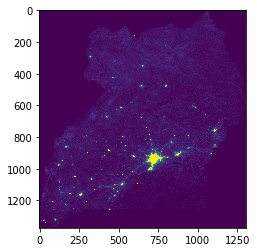

In [22]:
folder = Path('uganda') / 'viirs_clipped'

raster_merged, affine = merge_rasters(folder, percentile=70)
plt.imshow(raster_merged, vmin=0, vmax=1)

In [24]:
raster_merged_out = folder / 'VIIRS_Uganda_p70_new.tif'
save_raster(raster_merged_out, raster_merged, affine)

# Do something with MODIS?
Nah, seems to be pretty well filtered

# Create filter

In [3]:
ntl_filter = create_filter()

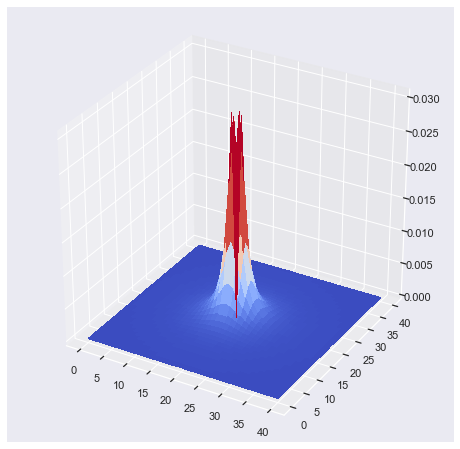

In [4]:
X = np.fromfunction(lambda i, j: i, ntl_filter.shape)
Y = np.fromfunction(lambda i, j: j, ntl_filter.shape)

fig = plt.figure(figsize=(8,8))
sns.set()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, ntl_filter, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Clip, filter and resample NTL

In [5]:
folder = Path('uganda')
ntl_in = folder / 'viirs_clipped/VIIRS_Uganda_p70.tif'
aoi_in = folder / 'uganda.gpkg'

In [6]:
ntl, ntl_filtered, ntl_interp, ntl_thresh, affine = prepare_ntl(ntl_in, aoi_in,
                                                                ntl_filter=ntl_filter,
                                                                threshold=2.1,
                                                                upsample_by=2)

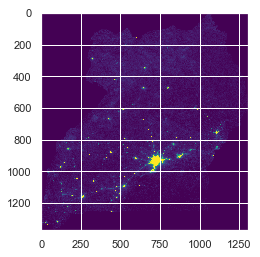

In [7]:
plt.imshow(ntl, cmap='viridis', vmin=0, vmax=1)

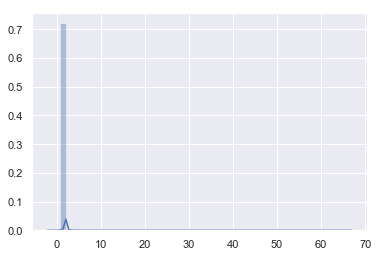

In [8]:
sns.distplot(ntl_filtered.flatten())

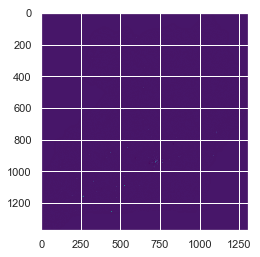

In [9]:
plt.imshow(ntl_filtered, cmap='viridis')

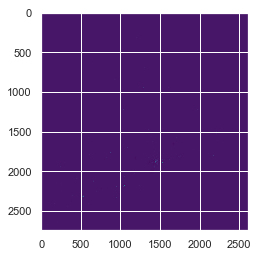

In [10]:
plt.imshow(ntl_interp, cmap='viridis')

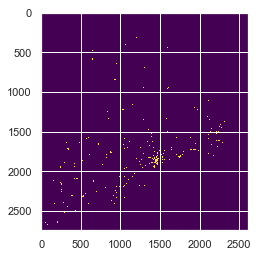

In [11]:
plt.imshow(ntl_thresh, cmap='viridis')

In [19]:
ntl_out = folder / 'ntl.tif'
save_raster(ntl_out, ntl_thresh, affine)

# Roads: assign values, clip and rasterize

In [12]:
roads_in = folder / 'uganda_roads.gpkg'
aoi_in = folder / 'uganda.gpkg'

In [ ]:
roads, roads_clipped, aoi, roads_raster, affine = prepare_roads(roads_in, aoi_in, ntl_thresh.shape, affine)

In [34]:
roads.head(2)

,highway,geometry,weight
0,service,"LINESTRING (32.657798 0.3479249, 32.6580256 0....",0.333333
1,service,"LINESTRING (32.6591916 0.3490086, 32.6591718 0...",0.333333


In [35]:
len(roads)

157800

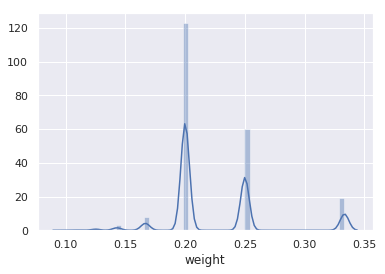

In [36]:
sns.distplot(roads['weight'])

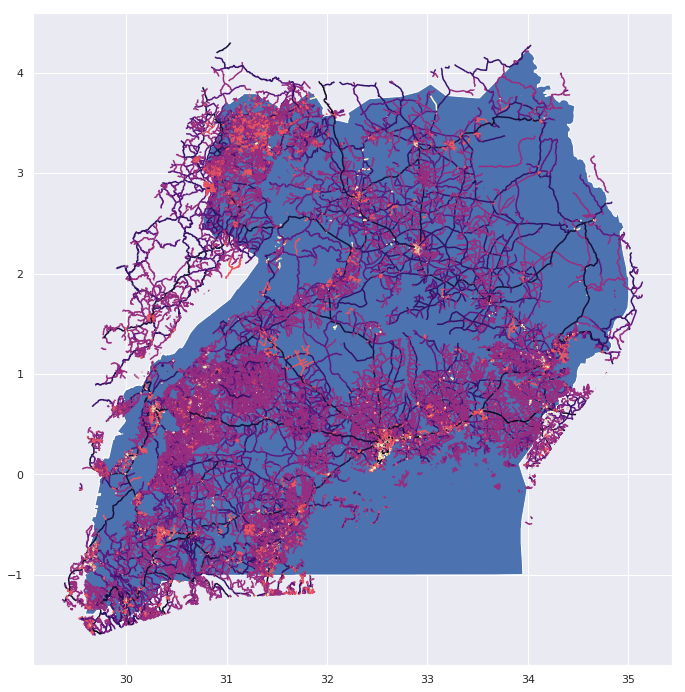

In [37]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca()
roads.plot(ax=ax, column='weight', cmap='magma')
aoi.plot(ax=ax)
plt.show()

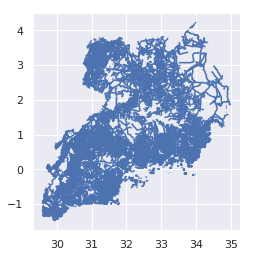

In [38]:
roads_clipped.plot()

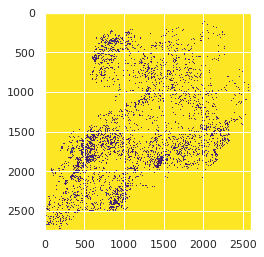

In [39]:
plt.imshow(roads_raster, cmap='viridis')

In [40]:
roads_out = folder / 'roads_raster.tif'
save_raster(roads_out, roads_raster, affine)

# Convert targets to list of coordinates

In [63]:
folder = Path('uganda')
targets_in = folder / 'ntl.tif'
costs_in = folder / 'roads.tif'

Affine:
 | 0.00, 0.00, 29.57|
| 0.00,-0.00, 4.24|
| 0.00, 0.00, 1.00|
Arrays same size: True
Start at: (37, 2116)


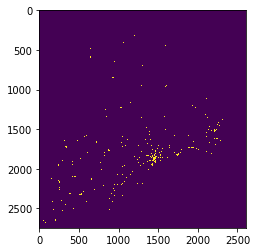

In [106]:
targets, costs, start, affine = get_targets_costs(targets_in, costs_in)
print('Affine:\n', affine)
print('Arrays same size:', targets.shape == costs.shape)
print('Start at:', start)
plt.imshow(targets, cmap='viridis')

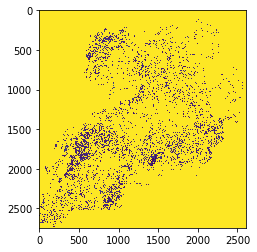

In [66]:
plt.imshow(costs.astype(np.float32), cmap='viridis')

In [68]:
targets.dtype

dtype('int8')

# Test targets and roads data

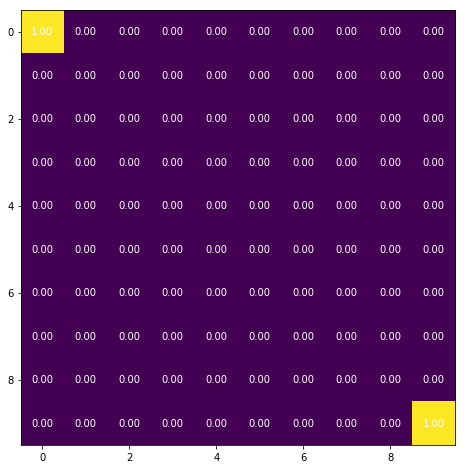

In [45]:
targets_test = np.zeros((10, 10))
targets_test[0, 0] = 1
targets_test[9, 9] = 1

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.imshow(targets_test, cmap='viridis')
for (j,i),label in np.ndenumerate(targets_test):
    ax.text(i,j,f'{label:.2f}',ha='center',va='center', color='white')

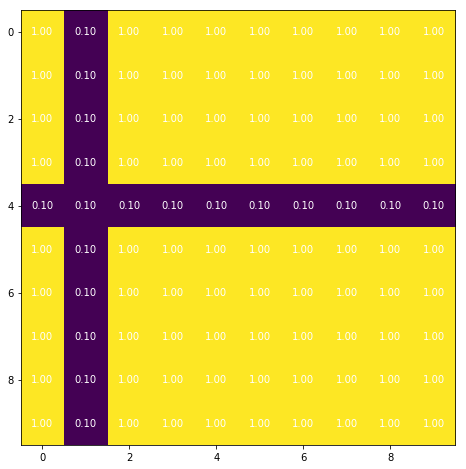

In [46]:
costs_test = np.ones_like(targets_test)
costs_test[:,1] = 0.1
costs_test[4,:] = 0.1

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.imshow(costs_test, cmap='viridis')
for (j,i),label in np.ndenumerate(costs_test):
    ax.text(i,j,f'{label:.2f}',ha='center',va='center', color='white')

In [47]:
start_test = (0,0)

# Run algorithm!

In [118]:
est_mem = estimate_mem_use(targets, costs)
print(f'Estimated memory usage: {est_mem:.2f} GB')

Estimated memory usage: 0.12 GB


In [18]:
dist, visited, prev = optimise(targets, costs, start, display_progress=True)

'99.00 %'

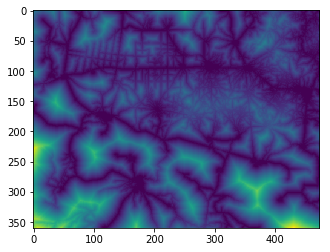

In [15]:
plt.imshow(dist)

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.imshow(dist, cmap='viridis')
for (j,i),label in np.ndenumerate(dist):
    ax.text(i, j, f'{label:.2f}', ha='center', va='center', color='white')

In [107]:
dist_out = folder / 'dist.tif'
save_raster(dist_out, dist, affine)

# Filter dist results to grid guess

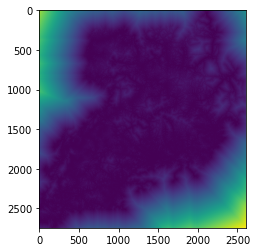

In [29]:
dists_in = folder / 'dist.tif'
dists_r, guess, transform = threshold(dists_in, cutoff=0.5)
plt.imshow(dists_r, cmap='viridis')

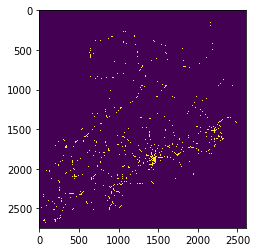

In [30]:
plt.imshow(guess, cmap='viridis')

In [31]:
guess_out = folder / 'guess-0.5.tif'
save_raster(guess_out, guess, transform)

# Check results

In [32]:
grid_in = folder / 'uganda_grid.gpkg'
guess_in = folder / 'guess-0.5.tif'
aoi_in = folder / 'uganda.gpkg'

true_pos, false_neg = accuracy(grid_in, guess_in, aoi_in)

In [33]:
print(f'Points identified as grid that are grid: {100*true_pos:.0f}%')

Points identified as grid that are grid: 85%


In [34]:
print(f'Actual grid that was missed: {100*false_neg:.0f}%')

Actual grid that was missed: 36%


# Convert to geometry

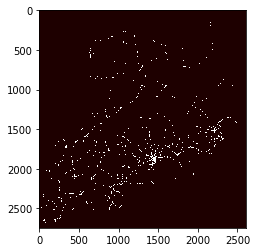

In [35]:
guess_in = folder / 'guess-0.5.tif'
guess_r, guess_geojson, guess_gdf = guess2geom(guess_in)
plt.imshow(guess_r, cmap='pink')

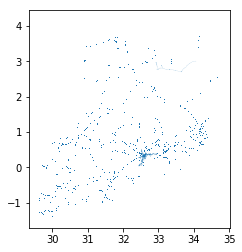

In [36]:
guess_gdf.plot()

In [37]:
guess_gdf.head()

,geometry,val
0,"POLYGON ((33.97708402766003 4.158334793017842,...",1.0
1,"POLYGON ((33.97708402766003 4.089584795804627,...",1.0
2,"POLYGON ((33.97916736090504 4.087501462555742,...",1.0
3,"POLYGON ((33.98125069415006 4.085418129306857,...",1.0
4,"POLYGON ((33.98333402739508 4.083334796057971,...",1.0


In [38]:
guess_vec_out = folder / 'guess_vec.gpkg'
guess_gdf.to_file(guess_vec_out, driver='GPKG')

/home/chris/anaconda3/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
CPLE_NotSupported in driver GPKG does not support creation option ENCODING
CPLE_NotSupported in dataset /home/chris/Documents/Code/gridfinder/uganda/guess_vec.gpkg does not support layer creation option ENCODING
CPLE_NotSupported in dataset /home/chris/Documents/Code/gridfinder/uganda/guess_vec.gpkg does not support layer creation option ENCODING
